In [41]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sn

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# PyTorch
import torch

# Hugging Face 
from transformers import pipeline

# Scikit-learn performance metrics
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score 
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc as calculate_auc

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import transformermodels as tm
print(f'Package version: {tm.__version__}')
print(f'PyTorch version: {torch.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Package version: 0.0.post1.dev3+g8362a6c.d20240713
PyTorch version: 2.3.1+cu121


In [2]:
# GPU checks
is_cuda = torch.cuda.is_available()
print(f'CUDA available: {is_cuda}')
print(f'Number of GPUs found:  {torch.cuda.device_count()}')

if is_cuda:
    print(f'Current device ID:     {torch.cuda.current_device()}')
    print(f'GPU device name:       {torch.cuda.get_device_name(0)}')
    print(f'CUDNN version:         {torch.backends.cudnn.version()}')
    device_str = 'cuda:0'
    torch.cuda.empty_cache() 
else:
    device_str = 'cpu'
device = torch.device(device_str)
print()
print(f'Device for model training/inference: {device}')

CUDA available: True
Number of GPUs found:  1
Current device ID:     0
GPU device name:       NVIDIA GeForce RTX 3070 Laptop GPU
CUDNN version:         8902

Device for model training/inference: cuda:0


In [3]:
# Basic usage of HuggingFace library
classifier = pipeline('sentiment-analysis', device=device)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [10]:
print(type(classifier))
test_strings = ['This is such a great movie!',
                'This show was not interesting.',
                'This show was not bad at all.',
                "I can't say that this was a good movie."]

for text in test_strings:
    print(text)
    print(classifier(text))
    print()

<class 'transformers.pipelines.text_classification.TextClassificationPipeline'>
This is such a great movie!
[{'label': 'POSITIVE', 'score': 0.9998759031295776}]

This show was not interesting.
[{'label': 'NEGATIVE', 'score': 0.9997904896736145}]

This show was not bad at all.
[{'label': 'POSITIVE', 'score': 0.9989770650863647}]

I can't say that this was a good movie.
[{'label': 'NEGATIVE', 'score': 0.9826217889785767}]



In [11]:
test_string = ['This course is just what I needed.',
               "I can't understand any of this. Instructor keeps telling me to meet the \
                prerequesites. What prerequesites? Why does he keep saying that?"]

print(classifier(test_string))

[{'label': 'POSITIVE', 'score': 0.9991594552993774}, {'label': 'NEGATIVE', 'score': 0.9964625239372253}]


In [15]:
data_dir = os.path.join(os.environ.get('HOME'), 'data', 'transformers')
csv_file = os.path.join(data_dir, 'AirlineTweets.csv')
df_ = pd.read_csv(csv_file)
display(df_.head())
df = df_[['airline_sentiment', 'text']].copy()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


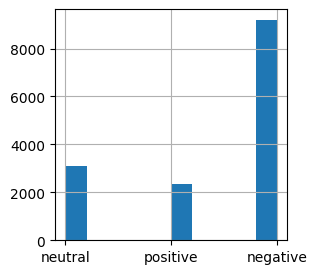

In [19]:
fig, ax = plt.subplots(figsize=(3, 3))
df['airline_sentiment'].hist(ax=ax)
plt.show()

In [24]:
df = df_[['airline_sentiment', 'text']].copy()
df = df.loc[df['airline_sentiment'] != 'neutral'].copy()

# Map the labels to integers
target_map = {'positive': 1, 'negative':0}
df = df.assign(target=df['airline_sentiment'].map(target_map))

display(df.head())
print(df['airline_sentiment'].unique())
print(df.shape)

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


['positive' 'negative']
(11541, 3)


In [26]:
# Create predictions from the model
texts = df['text'].tolist()
predictions = classifier(texts)

In [39]:
probs = [d.get('score') if d.get('label').startswith('P') else 1 - d.get('score') \
         for d in predictions]

preds = [1 if d.get('label').startswith('P') else 0 for d in predictions]

preds = np.array(preds)

# Get some binary classification metrics
print(f'acc: {np.mean(df["target"] == preds)}')
cm = confusion_matrix(df['target'], preds, normalize='true')
display(cm)

acc: 0.8898708950697514


array([[0.90117673, 0.09882327],
       [0.15404147, 0.84595853]])

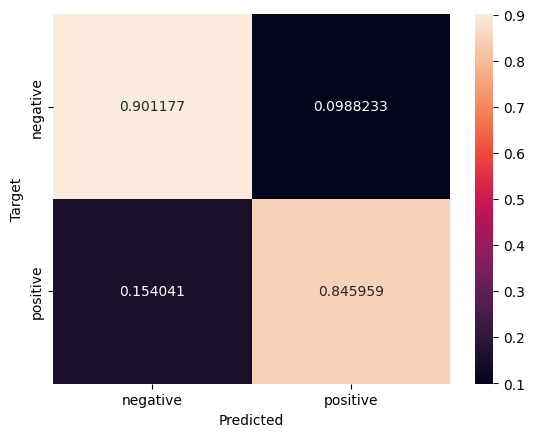

In [42]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
  classes = ['negative', 'positive']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)

In [46]:
print(f1_score(df['target'], preds))
print(f1_score(1 - df['target'], 1 - preds))
print(roc_auc_score(df['target'], probs))
print(roc_auc_score(1 - df['target'], 1 - np.array(probs)))

0.758777756690074
0.928647616908999
0.9485934460102435
0.9485934460102433
